# Практика построения регрессии

In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
df = pd.read_csv('botswana.csv', sep='\t')
df.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


In [29]:
df.religion.unique()

array(['catholic', 'protestant', 'spirit', 'other'], dtype=object)

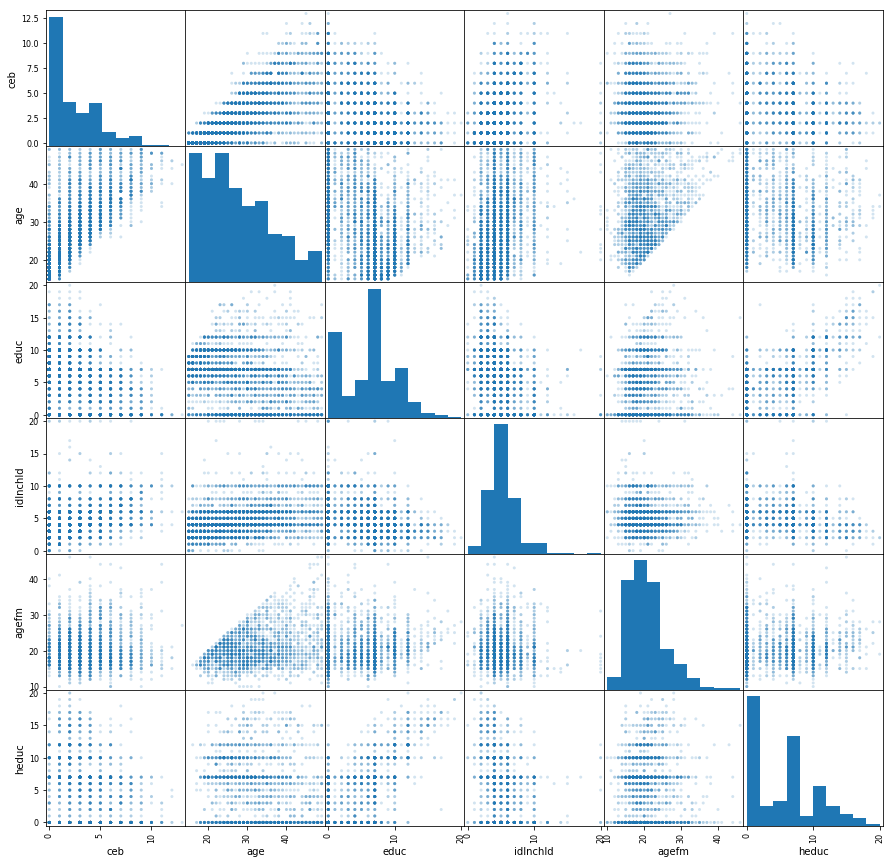

In [30]:
pd.plotting.scatter_matrix(df[['ceb', 'age', 'educ', 'idlnchld', 'agefm', 'heduc']], alpha=0.2, 
                                 figsize=(15, 15), diagonal='hist')
pylab.show()

### Распределение бинарных принаков

In [31]:
print df.knowmeth.value_counts()
print df.usemeth.value_counts()
print df.evermarr.value_counts()
print df.urban.value_counts()
print df.electric.value_counts()
print df.radio.value_counts()
print df.tv.value_counts()
print df.bicycle.value_counts()

1.0    4194
0.0     160
Name: knowmeth, dtype: int64
1.0    2478
0.0    1812
Name: usemeth, dtype: int64
0    2282
1    2079
Name: evermarr, dtype: int64
1    2253
0    2108
Name: urban, dtype: int64
0.0    3747
1.0     611
Name: electric, dtype: int64
1.0    3059
0.0    1300
Name: radio, dtype: int64
0.0    3954
1.0     405
Name: tv, dtype: int64
0.0    3156
1.0    1202
Name: bicycle, dtype: int64


### Что будет если удалить пропуски?

In [32]:
print df.shape
print df.dropna().shape 

(4361, 15)
(1834, 15)


#### В разных признаках пропуски возникают по разным причинам и должны обрабатываться по-разному. 

#### Например, в признаке agefm пропуски стоят только там, где evermarr=0, то есть, они соответствуют женщинам, никогда не выходившим замуж. Таким образом, для этого признака NaN соответствует значению "не применимо". 

#### В подобных случаях, когда признак x1 на части объектов в принципе не может принимать никакие значения, рекомендуется поступать так:
#### •создать новый бинарный признак: x2= 1 (x1=’не применимо’) или 0 (иначе);
         
#### •заменить "не применимо" в x1 на произвольную константу c, которая среди других значений x1 не встречается.

####  Теперь, когда мы построим регрессию на оба признака и получим модель вида: y=β0+β1*x1+β2*x2, 

#### на тех объектах, где x1 было измерено, регрессионное уравнение примет вид: y=β0+β1x, 

#### а там, где x1 было "не применимо", получится: y=β0+β1c+β2

#### Выбор c влияет только на значение и интерпретацию β2, но не β1

#### Давайте используем этот метод для обработки пропусков в agefm и heduc.

#### 1.Создайте признак nevermarr, равный единице там, где в agefm пропуски.

#### 2.Удалите признак evermarr — в сумме с nevermarr он даёт константу, значит, в нашей матрице X будет мультиколлинеарность.

#### 3.Замените NaN в признаке agefm на c=0

#### 4.У объектов, где nevermarr = 1, замените NaN в признаке heduc на -1 (ноль использовать нельзя, так как он уже встречается у некоторых объектов выборки).

In [33]:
df['nevermarr'] = df['evermarr'].map({0:1, 1:0})
data = df.drop('evermarr', axis=1)
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [34]:
data['agefm'][data['agefm'].isnull()]=0
data.loc[(data['heduc'].isnull()) & (data['agefm']==0),'heduc']=-1
data.head()

C:\Users\Vladuk\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [35]:
data['heduc'].isnull().sum()

123

### Избавимся от оставшихся пропусков.

### Для признаков idlnchld, heduc и usemeth проведите операцию, аналогичную предыдущей: создайте индикаторы пропусков по этим признакам (idlnchld_noans, heduc_noans, usemeth_noans), замените пропуски на нехарактерные значения (Сidlnchld=−1, Сheduc2=−2(значение -1 мы уже использовали), Сusemeth=−1)

### Остались только пропуски в признаках knowmeth, electric, radio, tv и bicycle. Их очень мало, так что удалите объекты, на которых их значения пропущены.


In [56]:
data['idlnchld'] = data['idlnchld'].fillna(-1)
data['idlnchld_noans'] = data['idlnchld'].map(lambda x: 1 if x == -1 else 0)
data['heduc'] = data['heduc'].fillna(-2)
data['heduc_noans'] = data['heduc'].map(lambda x: 1 if x == -2 else 0)
data['usemeth'] = data['usemeth'].fillna(-1)
data['usemeth_noans'] = data['usemeth'].map(lambda x: 1 if x == -1 else 0)
data.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0,0,0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0,0,0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0,0,0,0


In [57]:
data.isnull().sum()

ceb               0
age               0
educ              0
religion          0
idlnchld          0
knowmeth          7
usemeth           0
agefm             0
heduc             0
urban             0
electric          3
radio             2
tv                2
bicycle           3
nevermarr         0
idlnchld_noans    0
heduc_noans       0
usemeth_noans     0
dtype: int64

In [58]:
data.dropna(inplace=True)
data.shape

(4348, 18)

In [59]:
data.shape[0]*data.shape[1]

78264

### Постройте регрессию количества детей ceb на все имеющиеся признаки методом smf.ols

In [60]:
data.columns

Index([u'ceb', u'age', u'educ', u'religion', u'idlnchld', u'knowmeth',
       u'usemeth', u'agefm', u'heduc', u'urban', u'electric', u'radio', u'tv',
       u'bicycle', u'nevermarr', u'idlnchld_noans', u'heduc_noans',
       u'usemeth_noans'],
      dtype='object')

In [61]:
m1 = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + '\
       'usemeth + agefm + heduc + urban + electric + radio + tv + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans'\
        ,data=data)
fitted = m1.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        12:16:48   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

C:\Users\Vladuk\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


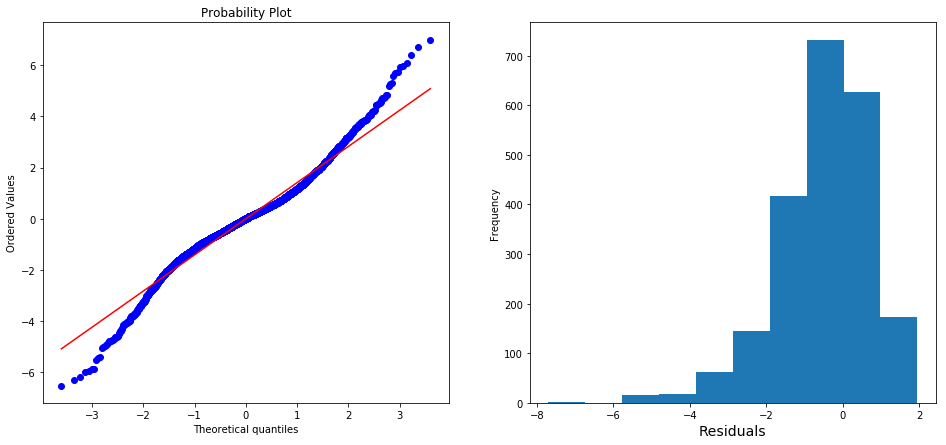

In [62]:
plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

### Проверьте критерием Бройша-Пагана гомоскедастичность ошибки в построенной модели. Выполняется ли она?

### Если ошибка гетероскедастична, перенастройте модель, сделав поправку Уайта типа HC1. 


In [63]:
print 'Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1] 

Breusch-Pagan test: p=0.000000


                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     345.0
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        12:17:33   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

C:\Users\Vladuk\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


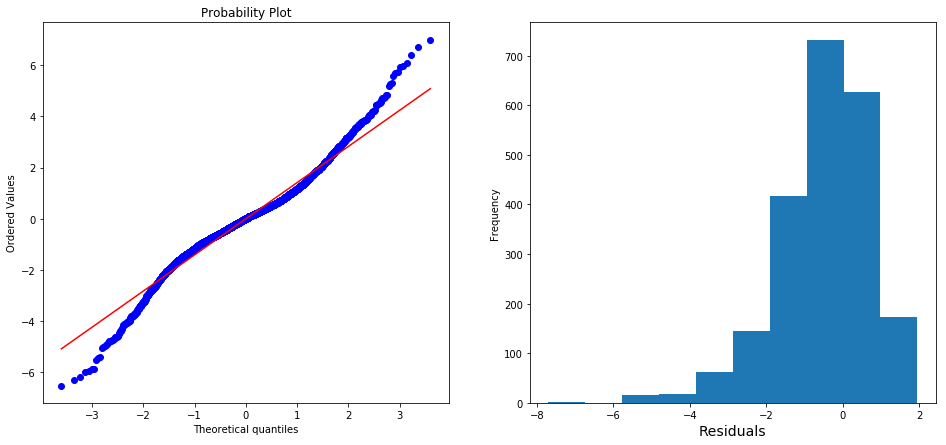

In [64]:
m2 = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + '\
       'usemeth + agefm + heduc + urban + electric + radio + tv + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans'\
        ,data=data)
fitted = m2.fit(cov_type='HC1')
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

### Удалите из модели незначимые признаки religion, radio и tv. Проверьте гомоскедастичность ошибки, при необходимости сделайте поправку Уайта. 

### Не произошло ли значимого ухудшения модели после удаления этой группы признаков? Проверьте с помощью критерия Фишера. Чему равен его достигаемый уровень значимости? Округлите до четырёх цифр после десятичной точки.

### Если достигаемый уровень значимости получился маленький, верните все удалённые признаки; если он достаточно велик, оставьте модель без религии, тв и радио.


In [65]:
data.drop(['religion','radio', 'tv'], axis=1, inplace=True)
data.head()

,ceb,age,educ,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1,0,0,0
1,2,43,11,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,0,0,0,0
2,0,49,4,4.0,1.0,0.0,22.0,1.0,1,1.0,0.0,0,0,0,0
3,0,24,12,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1,0,0,0
4,3,32,13,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,0,0,0,0


In [66]:
m3 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + '\
       'usemeth + agefm + heduc + urban + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans'\
        ,data=data)
fitted = m3.fit()
print fitted.summary()

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     559.5
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        12:18:13   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.198     -5.

In [67]:
print 'Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1] 

Breusch-Pagan test: p=0.000000


                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        12:18:41   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

C:\Users\Vladuk\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


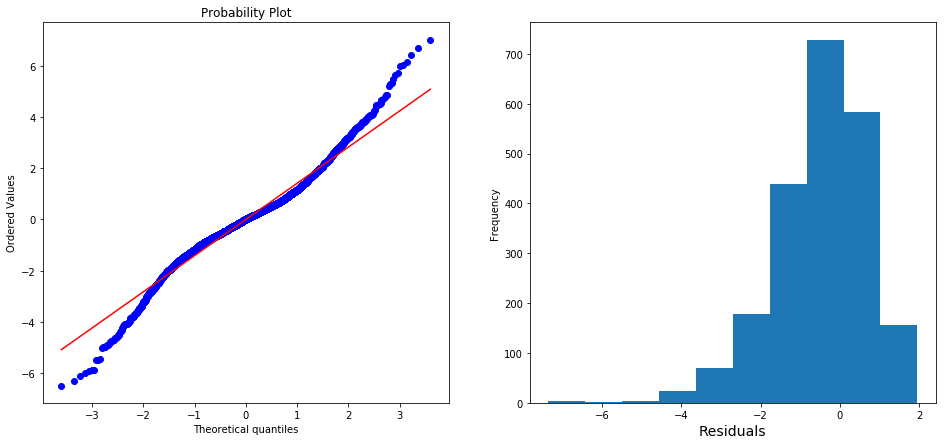

In [68]:
m4 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + '\
       'usemeth + agefm + heduc + urban + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans'\
        ,data=data)
fitted = m4.fit(cov_type='HC1')
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [69]:
print "F=%f, p=%f, k1=%f" % m2.fit().compare_f_test(m4.fit())

F=0.919236, p=0.467231, k1=5.000000


                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     396.4
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        12:21:22   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.262     -4.

C:\Users\Vladuk\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


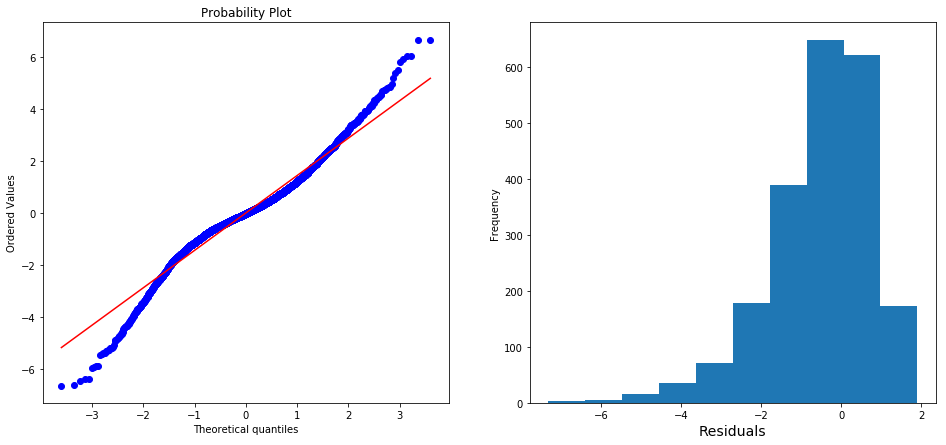

In [70]:
m5 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + '\
        'agefm + heduc + urban + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans '\
        ,data=data)
fitted = m5.fit(cov_type='HC1')
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

In [71]:
print "F=%f, p=%f, k1=%f" % m4.fit().compare_f_test(m5.fit())

F=92.890582, p=0.000000, k1=2.000000


                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        12:23:08   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

C:\Users\Vladuk\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


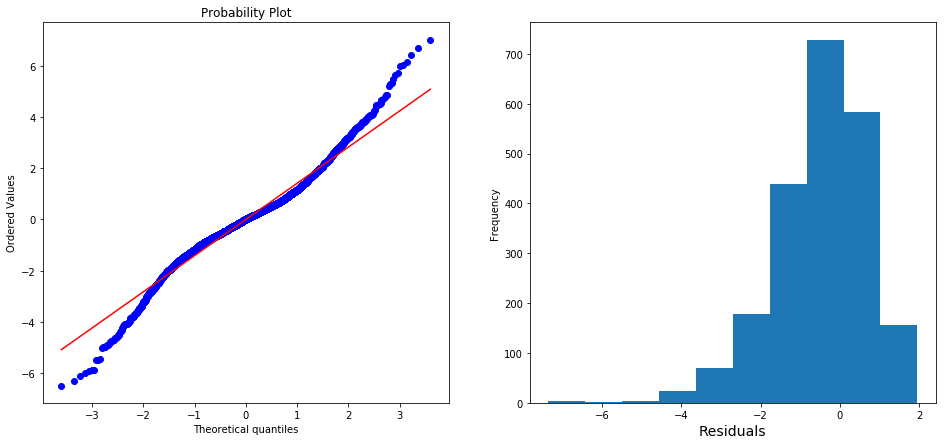

In [72]:
m4 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + '\
       'usemeth + agefm + heduc + urban + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans'\
        ,data=data)
fitted = m4.fit(cov_type='HC1')
print fitted.summary()

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

# Выводы

1) У женщин, никогда не выходивших замуж, при прочих равных в среднем на 2.3 ребёнка меньше (p<0.001, 95% доверительный интервал для разницы между средними — [-2.6, -1.9])

2) Итоговая модель объясняет 63% вариации отклика

3) У женщин, не знающих, какое количество детей идеально, в среднем на  
   βidlnchld_noans+Cidlnchld*βidlnchld≈0.58 детей больше

4) С увеличением возраста женщины на 1 год среднее количество детей возрастает на 0.17 (p<0.001, 95% доверительный интервал — [0.16, 0.18])



